# Importing necessary libraries for model building and analysis

In [1]:
import tensorflow as tf
from tensorflow.keras import models , layers
import matplotlib.pyplot as plt

# Defining image and batch size along with rgb channel and 50 epochs

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=50

# Retrieving data of defined image size and batch size along with suffling

In [3]:
 dataset = tf.keras.preprocessing.image_dataset_from_directory(
         "datasets",
          shuffle=True,
          image_size=(IMAGE_SIZE,IMAGE_SIZE),
          batch_size=BATCH_SIZE
)

Found 6575 files belonging to 4 classes.


# Checking out class names and outputting some pictures with their label for verifying

In [4]:
class_names = dataset.class_names
class_names

['Not_a_Tomato_Leaf',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_healthy']

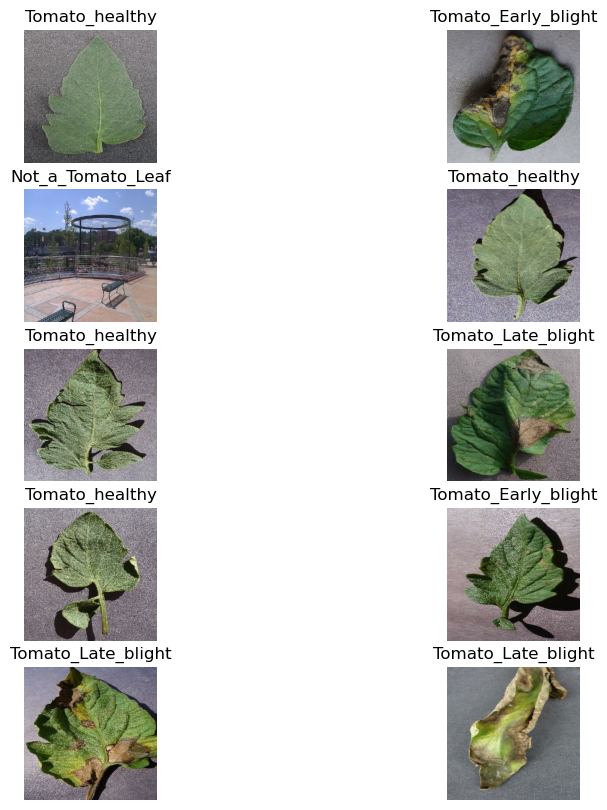

In [5]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(10):
        plt.subplot(5,2,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
        
    

# The function below implements partitioning of the whole dataset to train , test and validation

In [6]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
   
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [7]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [8]:
len(val_ds)

20

# Cache shuffling and Prefetching done for faster calculation

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Image augmentation applied along with resizing and rescaling

In [10]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [11]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

# This part implements the core architecture of the model

In [12]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(64, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'), 
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

# Summary of the model

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

# compiling and fitting of model 

In [14]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [15]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
164/164 [==============================] - 558s 3s/step - loss: 0.8756 - accuracy: 0.6005 - val_loss: 0.6501 - val_accuracy: 0.7656
Epoch 2/50
164/164 [==============================] - 364s 2s/step - loss: 0.5121 - accuracy: 0.7874 - val_loss: 0.3872 - val_accuracy: 0.8609
Epoch 3/50
164/164 [==============================] - 353s 2s/step - loss: 0.4262 - accuracy: 0.8301 - val_loss: 0.3845 - val_accuracy: 0.8438
Epoch 4/50
164/164 [==============================] - 364s 2s/step - loss: 0.3537 - accuracy: 0.8612 - val_loss: 0.3257 - val_accuracy: 0.8609
Epoch 5/50
164/164 [==============================] - 357s 2s/step - loss: 0.3056 - accuracy: 0.8773 - val_loss: 0.3821 - val_accuracy: 0.8562
Epoch 6/50
164/164 [==============================] - 356s 2s/step - loss: 0.2597 - accuracy: 0.8977 - val_loss: 0.2116 - val_accuracy: 0.9234
Epoch 7/50
164/164 [==============================] - 370s 2s/step - loss: 0.2541 - accuracy: 0.8996 - val_loss: 0.1960 - val_accuracy: 0.9297

164/164 [==============================] - 528s 3s/step - loss: 0.0284 - accuracy: 0.9895 - val_loss: 0.0208 - val_accuracy: 0.9906
Epoch 42/50
164/164 [==============================] - 538s 3s/step - loss: 0.0320 - accuracy: 0.9891 - val_loss: 0.2147 - val_accuracy: 0.9516
Epoch 43/50
164/164 [==============================] - 555s 3s/step - loss: 0.0949 - accuracy: 0.9694 - val_loss: 0.0765 - val_accuracy: 0.9734
Epoch 44/50
164/164 [==============================] - 501s 3s/step - loss: 0.0614 - accuracy: 0.9790 - val_loss: 0.0568 - val_accuracy: 0.9797
Epoch 45/50
164/164 [==============================] - 580s 4s/step - loss: 0.0301 - accuracy: 0.9899 - val_loss: 0.0663 - val_accuracy: 0.9766
Epoch 46/50
164/164 [==============================] - 535s 3s/step - loss: 0.0777 - accuracy: 0.9757 - val_loss: 0.0418 - val_accuracy: 0.9859
Epoch 47/50
164/164 [==============================] - 585s 4s/step - loss: 0.0216 - accuracy: 0.9937 - val_loss: 0.0415 - val_accuracy: 0.9875
Epoc

In [16]:
scores = model.evaluate(test_ds)

22/22 [==============================] - 99s 382ms/step - loss: 0.1258 - accuracy: 0.9688


# Analysis on training and validation accuracy and loss graph over 50 epochs

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

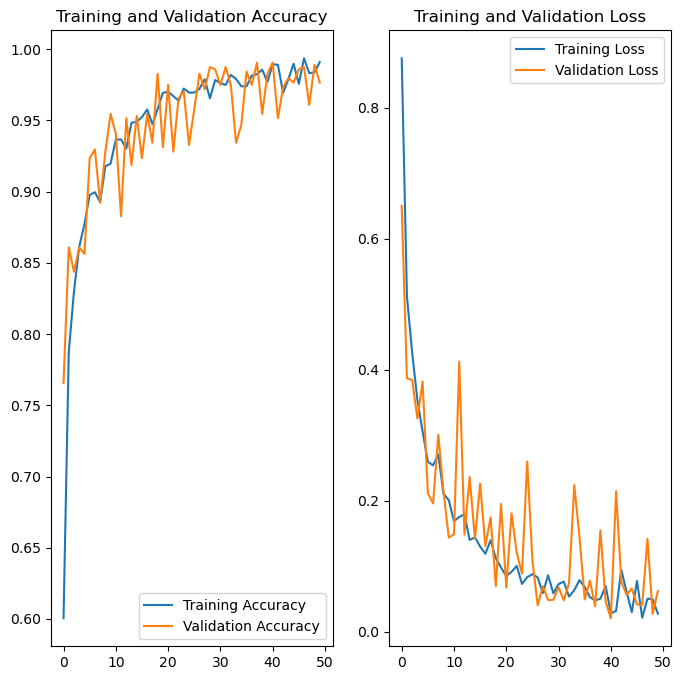

In [18]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Informal raw prediction part

first image to predict
actual label: Tomato_healthy
1/1 [==============================] - 1s 731ms/step
predicted label: Tomato_healthy


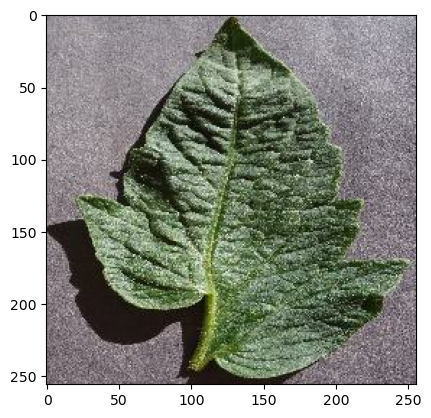

In [19]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# Formal prediction function implemented

In [21]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# verifying predict function

1/1 [==============================] - 0s 50ms/step


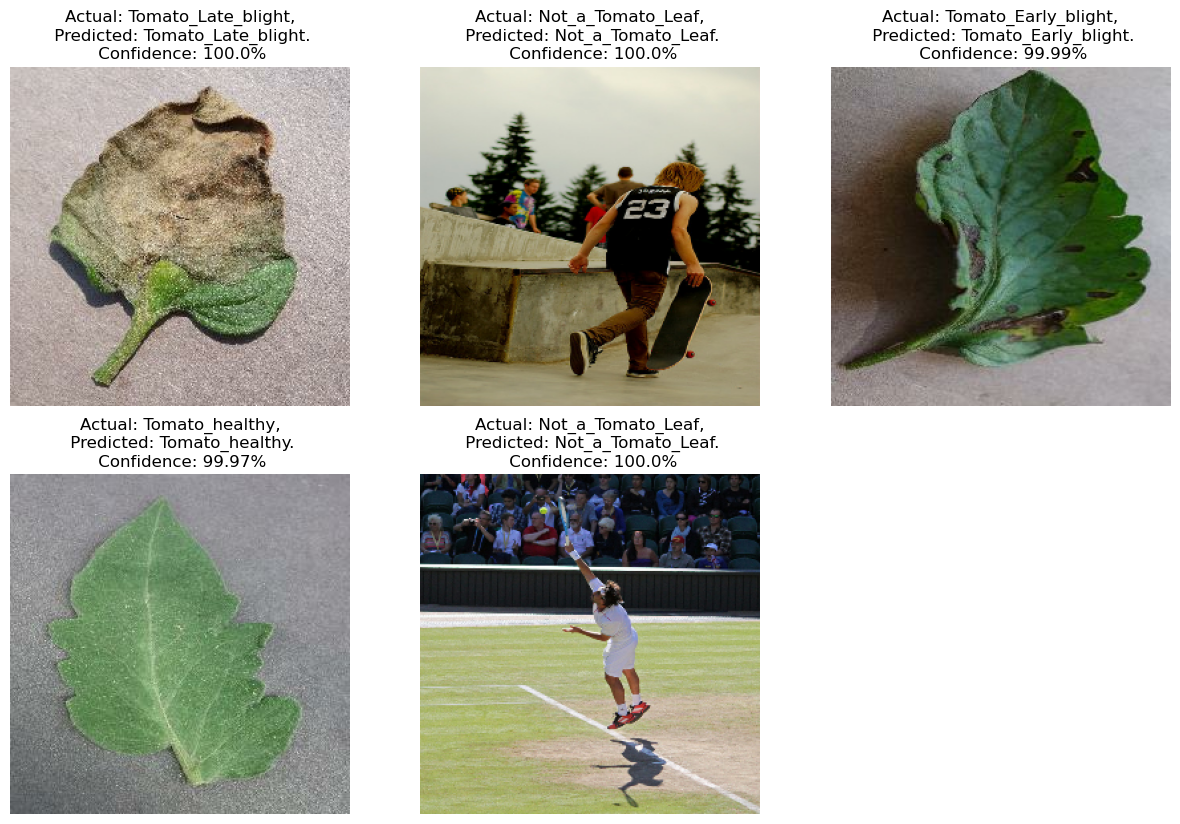

In [22]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(5):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Saving the model as a specific version

In [23]:
model.save("0.0.4")

INFO:tensorflow:Assets written to: 0.0.4\assets


INFO:tensorflow:Assets written to: 0.0.4\assets
